In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score

random.seed(12)

data = pd.read_csv('/content/drive/MyDrive/thesis/Redo/feature selection/overlaping Optimal biomarkers evaluation/data/myDataset_numerized_severity_lfc_1_DEGs_transposed_biomarkers_only.csv')

y_train = data.iloc[:, -1].values
X_train = data.iloc[:, :-1].values


#RF evaluation using 5-fold cross validation(CV)
clf_true = RandomForestClassifier(n_estimators=100 , random_state=42)

#cv predictions
y_pred_cv = cross_val_predict(clf_true, X_train, y_train, cv=5)

#confusion matrix
cm = confusion_matrix(y_train, y_pred_cv)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# CV accuracy
cv_scores_accuracy = cross_val_score(clf_true, X_train, y_train, cv=5)

print("Cross-Validation Accuracy Scores:", cv_scores_accuracy)
print("Mean Accuracy:", np.mean(cv_scores_accuracy))
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)


Cross-Validation Accuracy Scores: [0.95 0.75 0.8  0.7  0.9 ]
Mean Accuracy: 0.8200000000000001
Sensitivity (Recall): 0.8163265306122449
Specificity: 0.8235294117647058


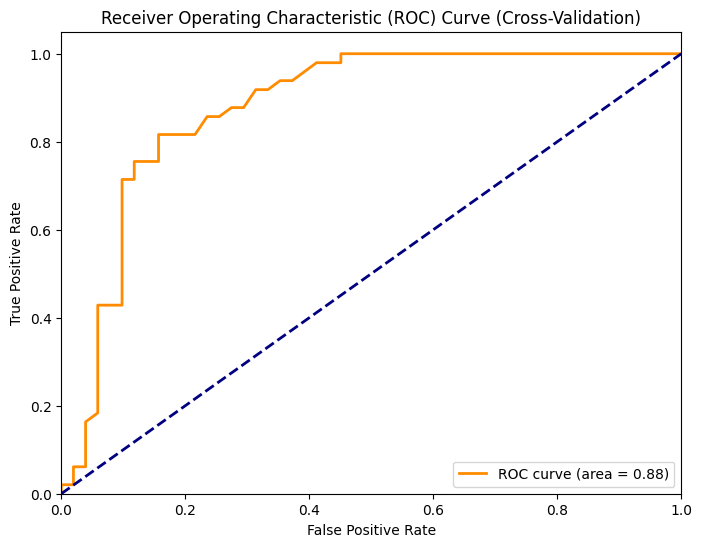

In [3]:
# ROC evaluation
y_true_prob_cv_true = cross_val_predict(clf_true, X_train, y_train, cv=5, method='predict_proba')[:, 1]

fpr_cv_true, tpr_cv_true, thresholds_cv_true = roc_curve(y_train, y_true_prob_cv_true)

roc_auc_cv_true = roc_auc_score(y_train, y_true_prob_cv_true)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_cv_true, tpr_cv_true, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_cv_true))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Cross-Validation)')
plt.legend(loc="lower right")
plt.show()

In [4]:
# Trial on the top 5 features
cv_results_true = cross_validate(clf_true, X_train, y_train, cv=5, return_train_score=False, return_estimator=True)

clf_true_fitted = cv_results_true['estimator'][-1]
feature_importances = clf_true_fitted.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': data.columns[:-1], 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_5_features = feature_importance_df.head(5)

print("Top 5 Features:")
print(top_5_features)


Top 5 Features:
           Feature  Importance
201            TXN    0.036820
10         ALOX5AP    0.030399
189  TIMM23B.AGAP6    0.030010
58          DUSP13    0.029997
78          GPR174    0.024473


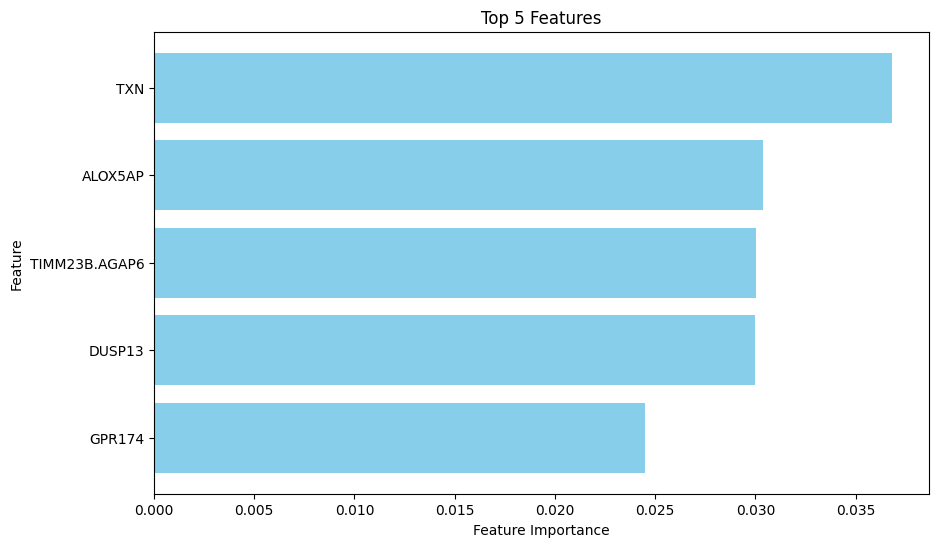

In [5]:
# Plotting the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_5_features['Feature'], top_5_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 5 Features')
plt.gca().invert_yaxis()
plt.show()

Top 10 Features:
           Feature  Importance
201            TXN    0.036820
10         ALOX5AP    0.030399
189  TIMM23B.AGAP6    0.030010
58          DUSP13    0.029997
78          GPR174    0.024473
134         OTUD7A    0.023149
3             ACE2    0.021762
145          PTCH1    0.021393
211        ZNF280B    0.020246
151           RADX    0.019024


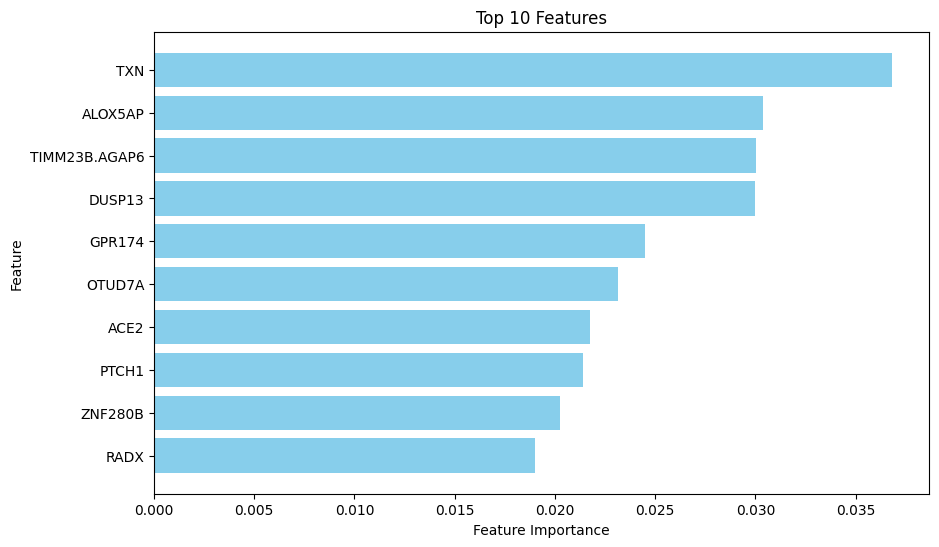

In [6]:
# Top 5 features
top_10_features = feature_importance_df.head(10)

print("Top 10 Features:")
print(top_10_features)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features')
plt.gca().invert_yaxis()
plt.show()

In [7]:
# Random Forest classifier evaluation using only the top 5 features, 5-fold cv
clf_top5 = RandomForestClassifier(n_estimators=100, random_state=42)
X_train_top5 = data[top_5_features['Feature']].values


cv_scores_accuracy_top5 = cross_val_score(clf_top5, X_train_top5, y_train, cv=5)

print("Cross-Validation Accuracy Scores:", cv_scores_accuracy_top5)
print("Mean Accuracy:", np.mean(cv_scores_accuracy_top5))



Cross-Validation Accuracy Scores: [0.85 0.8  0.8  0.7  0.75]
Mean Accuracy: 0.78


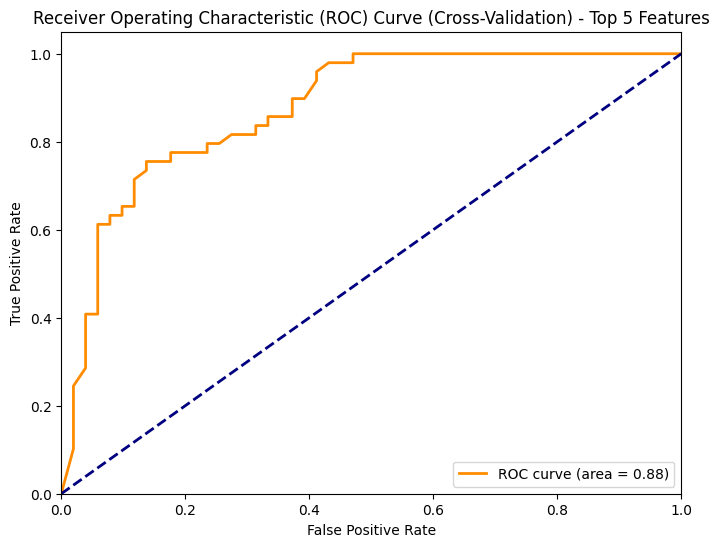

In [8]:
# ROC evaluation with the top 5 features

y_true_prob_cv_top5 = cross_val_predict(clf_top5, X_train_top5, y_train, cv=5, method='predict_proba')[:, 1]
fpr_cv_top5, tpr_cv_top5, thresholds_cv_top5 = roc_curve(y_train, y_true_prob_cv_top5)

roc_auc_cv_top5 = roc_auc_score(y_train, y_true_prob_cv_top5)

plt.figure(figsize=(8, 6))
plt.plot(fpr_cv_top5, tpr_cv_top5, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_cv_top5))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Cross-Validation) - Top 5 Features')
plt.legend(loc="lower right")
plt.show()

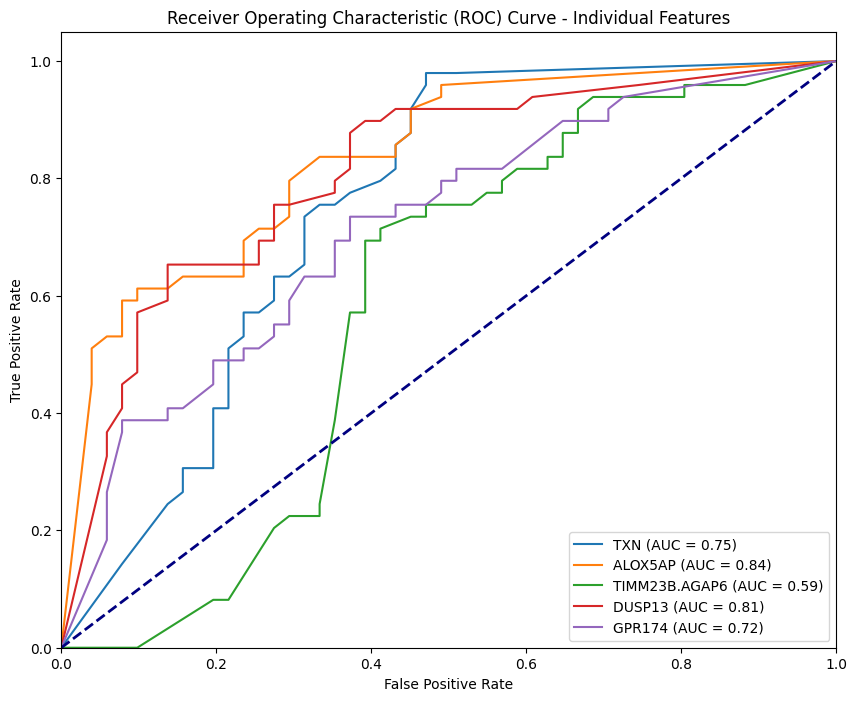

In [9]:
#  ROC curve evaluation for each of the top 5 features individually
plt.figure(figsize=(10, 8))
for i, feature in enumerate(top_5_features['Feature']):
    X_train_single_feature = data[[feature]].values
    y_true_prob_cv_single_feature = cross_val_predict(clf_top5, X_train_single_feature, y_train, cv=5, method='predict_proba')[:, 1]

    fpr_cv_single_feature, tpr_cv_single_feature, _ = roc_curve(y_train, y_true_prob_cv_single_feature)

    auc_value = roc_auc_score(y_train, y_true_prob_cv_single_feature)

    plt.plot(fpr_cv_single_feature, tpr_cv_single_feature, label=f'{feature} (AUC = {auc_value:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Individual Features')

plt.legend(loc="lower right")
plt.show()
